In [1]:
import os
import sys


project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.append(project_root)



import torch
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import wandb
from modules.utils import load_runs_final_artifact
from modules.models import TCN_channel, TCN, memory_polynomial_channel
from modules.utils import *
import pandas as pd
import seaborn as sns
import pickle
from matplotlib import cm
from scipy import stats




DEVICE = torch.device("cpu")
print("DEVICE", DEVICE)
ENTITY = "dylanbackprops-university-of-washington"
PROJECT = "mldrivenpeled"

DEVICE cpu


In [2]:
# Set plotting variables


plt.rcParams.update({
    'font.size': 8,
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial', 'Helvetica'],
    'axes.labelsize': 9,
    'axes.titlesize': 9,
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'legend.fontsize': 8,
    'figure.dpi': 100,
    'lines.linewidth': 1.0,
    'lines.markersize': 4,
    'xtick.direction': 'in', 
    'ytick.direction': 'in',
    'axes.linewidth': 0.8
    })

In [3]:
models = {
    "48mA": {
        'ofdm_info': extract_zarr_data( "..\data\channel_measurements\zarr_files\channel_3e5-7.6MHz_2.68.V_0.125A_48mA_scale2_dynamic_power_0.5-3_v2.zarr", DEVICE),
        'tcn_channel': "comfy-sweep-115",
        'encoder_decoder_tcn': "volcanic-galaxy-403",
        'memory_polynomial':'blank',
        'encoder_decoder_mp':'blank',
        'grid_search':"yqzp2ezq"
    },
        "60mA": {
        'ofdm_info': extract_zarr_data( "..\data\channel_measurements\zarr_files\channel_3e5-9.2MHz_2.775.V_0.129A_60ma_scale2_dynamic_power_0.5-3.zarr", DEVICE),
        'tcn_channel': "snowy-sweep-4",
        'encoder_decoder_tcn': "blank",
        'memory_polynomial':'blank',
        'encoder_decoder_mp':'blank',
        'grid_search':"jlwt6o4d"
    }
}

c:\Users\maild\mldrivenpeled\modules\utils.py:65: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(cache_path, map_location=device)


Loaded from cache!
Loaded from cache!


In [4]:
# Iterate over different current levels and fit memory polynomial models
for current_level, model_info in models.items():
    ofdm_info = model_info['ofdm_info']
    mp_model = memory_polynomial_channel(weights=None, memory_linear=10, memory_nonlinear=10, nonlinearity_order=2, device=torch.device('cpu'))
    _, _ , _ = mp_model.fit(ofdm_info.sent_frames_time, ofdm_info.received_frames_time)
    model_info['memory_polynomial'] = mp_model

Loading from ../models\channel_models\comfy-sweep-115\channel_model_final.pth


c:\Users\maild\mldrivenpeled\modules\utils.py:394: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights = torch.load(local_weights_path, map_location="cpu")


Loading from ../models\channel_models\snowy-sweep-4\channel_model_final.pth


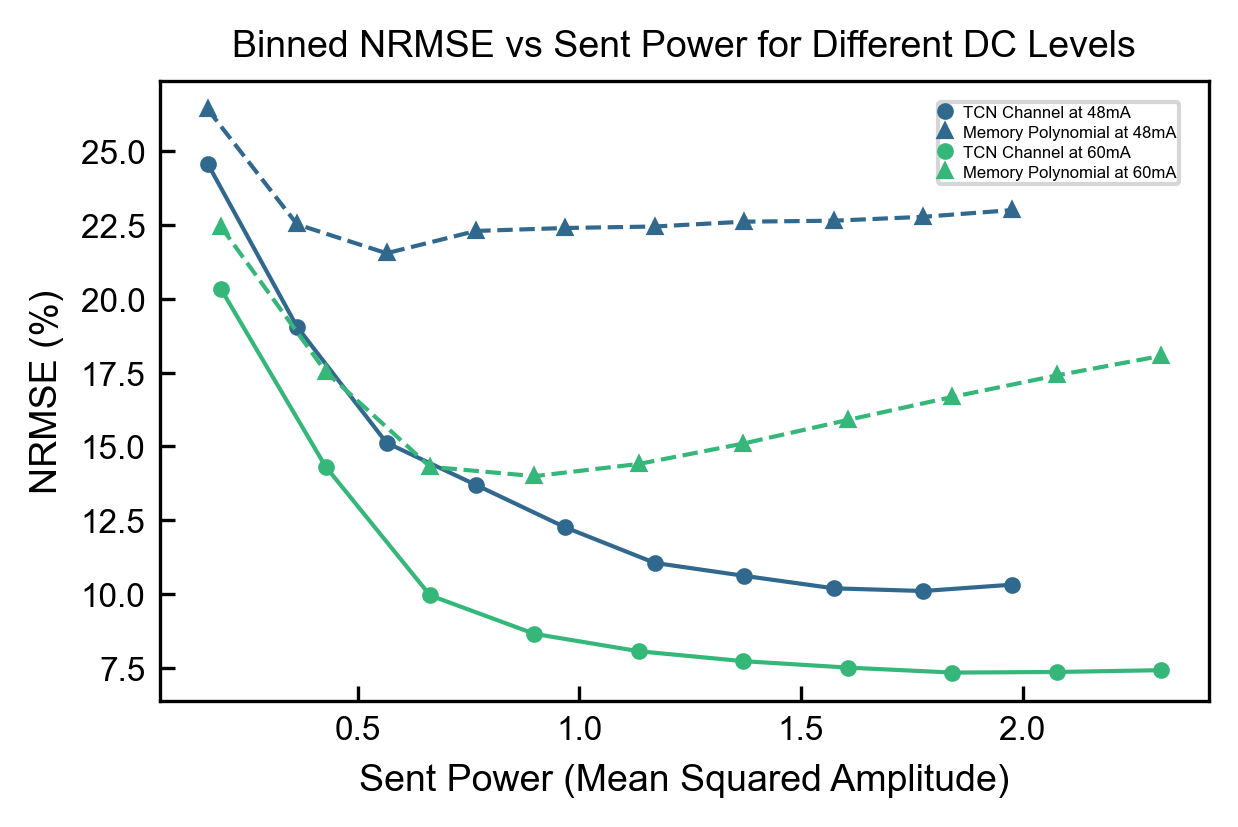

In [5]:
# G2 Plot

plt.rcParams.update({
    'figure.dpi': 300
})

# Create scale of colors for different current levels
current_levels = list(models.keys())
num_levels = len(current_levels)
color_palette = sns.color_palette("viridis", num_levels)

    # Make one large figure with binned NRMSE for each current level
plt.figure(figsize=(4, 2.8))
for current_level, model_info in models.items():
    ofdm_info = model_info['ofdm_info']
    X = ofdm_info.sent_frames_time.to(DEVICE)
    Y = ofdm_info.received_frames_time.to(DEVICE)
    mp_model = model_info['memory_polynomial']
    tcn_model, tcn_cfg = load_runs_final_artifact(model_info['tcn_channel'], DEVICE, model_type='channel')


    # Divide into N power bins and compare NRMSE
    N = 10
    sent_powers = X.square().mean(dim=-1)
    pwr_min = sent_powers.min()
    pwr_max = sent_powers.max()

    bins = torch.linspace(pwr_min, pwr_max, N + 1)
    bin_ids = torch.bucketize(sent_powers, bins)
    binned_losses = torch.zeros(N, 2)
    for i in range(N):
        mask = bin_ids == i
        if mask.any():
            filtered_x = X[mask]
            filtered_y = Y[mask]
            noisy_y_pred, y_pred_tcn, std_y_pred, nu_y_pred = tcn_model(filtered_x)
            tcn_rmse_loss = calculate_rmse_pct_loss(filtered_y, y_pred_tcn)
            mp_y_pred = mp_model(filtered_x)
            mp_rmse_loss = calculate_rmse_pct_loss(filtered_y, mp_y_pred)
            binned_losses[i, 0] = tcn_rmse_loss
            binned_losses[i, 1] = mp_rmse_loss
        else:
            binned_losses[i, 0] = torch.nan
            binned_losses[i, 1] = torch.nan

    # Plot binned losses
    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    plt.plot(bin_centers.cpu(), binned_losses[:, 0].cpu(), color=color_palette[current_levels.index(current_level)], marker='o', markersize=3, linestyle='-', label=f'TCN Channel at {current_level}')
    plt.plot(bin_centers.cpu(), binned_losses[:, 1].cpu(), color=color_palette[current_levels.index(current_level)], marker='^', markersize=3, linestyle='--', label=f'Memory Polynomial at {current_level}')           

plt.title("Binned NRMSE vs Sent Power for Different DC Levels")
plt.xlabel("Sent Power (Mean Squared Amplitude)")
plt.legend(
    fontsize=4,
    handlelength=0.5,
    labelspacing=0.3,
    borderpad=0.2,
    loc="best",
    bbox_to_anchor=(0.98, 0.98)
)
plt.tight_layout()
plt.ylabel("NRMSE (%)")
plt.show()        


Loading from cache!


C:\Users\maild\AppData\Local\Temp\ipykernel_24904\3590919578.py:72: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(


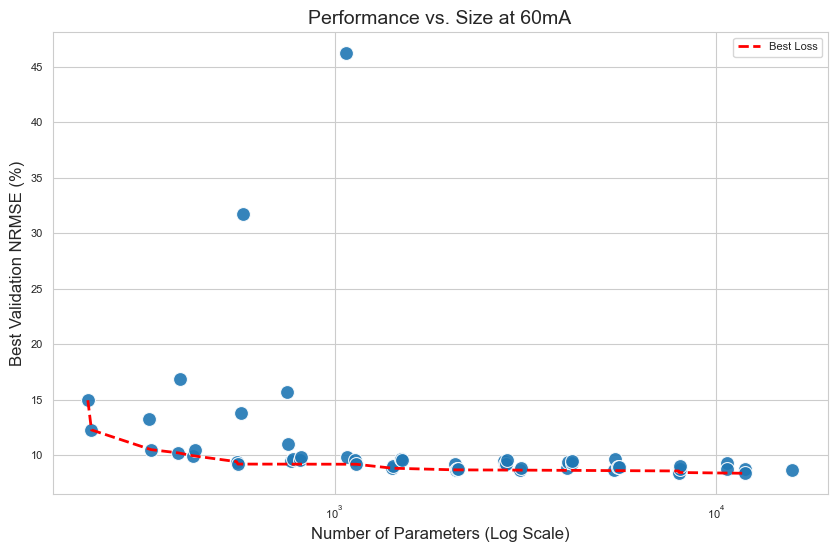

In [ ]:
#G4: Get Models for a Sweep and Plot Best Val NMRSE loss vs parameter count

plt.rcParams.update({
    'figure.dpi': 100
})


cmap = plt.get_cmap("viridis")
c_runs  = cmap(0.3)
c_best = cmap(0.9)

def plot_sweep_pareto(sweep_id, entity, project):
    """
    Fetches all runs from a W&B sweep and plots Best Val NRMSE vs Parameter Count.
    
    Args:
        sweep_id (str): The ID of the sweep.
        entity (str): Your W&B username or team name.
        project (str): The project name.
    """

    # Check if sweep id is cached in plot data
    cache_file = f"cache_{sweep_id}.pkl"
    cache_path = os.path.join(project_root, f"data/plots/{cache_file}")
    if os.path.exists(cache_path):
        print("Loading from cache!")
        with open(cache_path, 'rb') as f:
            sweep_data = pickle.load(f)    

    else:
        print("Getting from API")

        api = wandb.Api()

        path = f"{entity}/{project}/{sweep_id}" 
        sweep = api.sweep(path)

        # save in pickle file   
        os.makedirs(os.path.dirname(cache_path), exist_ok=True)
        sweep_data = []
        
        for run in sweep.runs:
            # Skip failed/crashed runs
            if run.state != "finished":
                continue
            num_params = run.config.get('num_params')
            
            val_nrmse = run.summary.get('avg_nrmse_pct_loss')
        
            sweep_data.append({
                "params": num_params,
                "nrmse_pct": val_nrmse,
                "run_name": run.name
            })

        with open(cache_path, 'wb') as f:
            pickle.dump(sweep_data, f)

    df = pd.DataFrame(sweep_data)
    
    df = df.sort_values("params")
    
    pareto_points = []
    current_min_error = float('inf')

    for _, row in df.iterrows():
        if row['nrmse_pct'] < current_min_error:
            pareto_points.append(row)
            current_min_error = row['nrmse_pct']
            
    pareto_df = pd.DataFrame(pareto_points)

    plt.figure(figsize=(10, 6))
    sns.set_style("whitegrid")
    
    # Scatter all runs
    sns.scatterplot(
        data=df, 
        x='params', 
        y='nrmse_pct', 
        s=100, 
        alpha=0.9, 
        color=c_runs,
        label='All Runs'
    )
    
    # Draw Pareto Line
    plt.plot(
        pareto_df['params'], 
        pareto_df['nrmse_pct'], 
        linestyle='--', 
        linewidth=2, 
        label='Best Loss',
        color=c_best
    )
    
    plt.xscale('log')
    plt.xlabel('Number of Parameters (Log Scale)', fontsize=12)
    plt.ylabel('Best Validation NRMSE (%)', fontsize=12)
    plt.title(f'Performance vs. Size at {DC_BIAS}', fontsize=14)
    plt.legend(loc='upper right')
    
    
    plt.show()

DC_BIAS = '60mA'

SWEEP_ID = models['60mA']['grid_search']

plot_sweep_pareto(SWEEP_ID, entity=ENTITY, project=PROJECT)

In [7]:
# # Analyze Experimental Validation Data
# validations = {
#     "dazzling-leaf-8110": {
#         "encoder_decoder": "scarlet-spaceship-8109"
#     }
# }

# root_val_path = os.path.abs(os.path.join(project_root, "data/validation_measurements"))
# for val in validations.keys():
#     data_path = os.path.join(root_val_path, f"{val}.zarr")
#     data = extract_zarr_data(data_path, device=torch.device('cpu'))

Loading from ../models\channel_models\comfy-sweep-115\channel_model_final.pth
Is model Gaussian? False
Mean Nu Prediction at power 0.50: 7.0241 Max Nu Prediction: 15.7828 Min Nu Prediction: 2.0000                 Mean Std Prediction: 0.0063 | Max Std Prediction: 0.0245 Min Std Prediction: 0.0015


c:\Users\maild\mldrivenpeled\modules\utils.py:394: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights = torch.load(local_weights_path, map_location="cpu")


Mean Nu Prediction at power 0.78: 6.5906 Max Nu Prediction: 17.9897 Min Nu Prediction: 2.0000                 Mean Std Prediction: 0.0063 | Max Std Prediction: 0.0316 Min Std Prediction: 0.0009
Mean Nu Prediction at power 1.06: 6.1890 Max Nu Prediction: 17.9324 Min Nu Prediction: 2.0000                 Mean Std Prediction: 0.0063 | Max Std Prediction: 0.0548 Min Std Prediction: 0.0008
Mean Nu Prediction at power 1.33: 5.8477 Max Nu Prediction: 18.7947 Min Nu Prediction: 2.0000                 Mean Std Prediction: 0.0063 | Max Std Prediction: 0.0460 Min Std Prediction: 0.0007
Mean Nu Prediction at power 1.61: 5.5486 Max Nu Prediction: 20.0077 Min Nu Prediction: 2.0000                 Mean Std Prediction: 0.0063 | Max Std Prediction: 0.0528 Min Std Prediction: 0.0006
Mean Nu Prediction at power 1.89: 5.3037 Max Nu Prediction: 23.1773 Min Nu Prediction: 2.0000                 Mean Std Prediction: 0.0062 | Max Std Prediction: 0.0989 Min Std Prediction: 0.0004
Mean Nu Prediction at power 2.

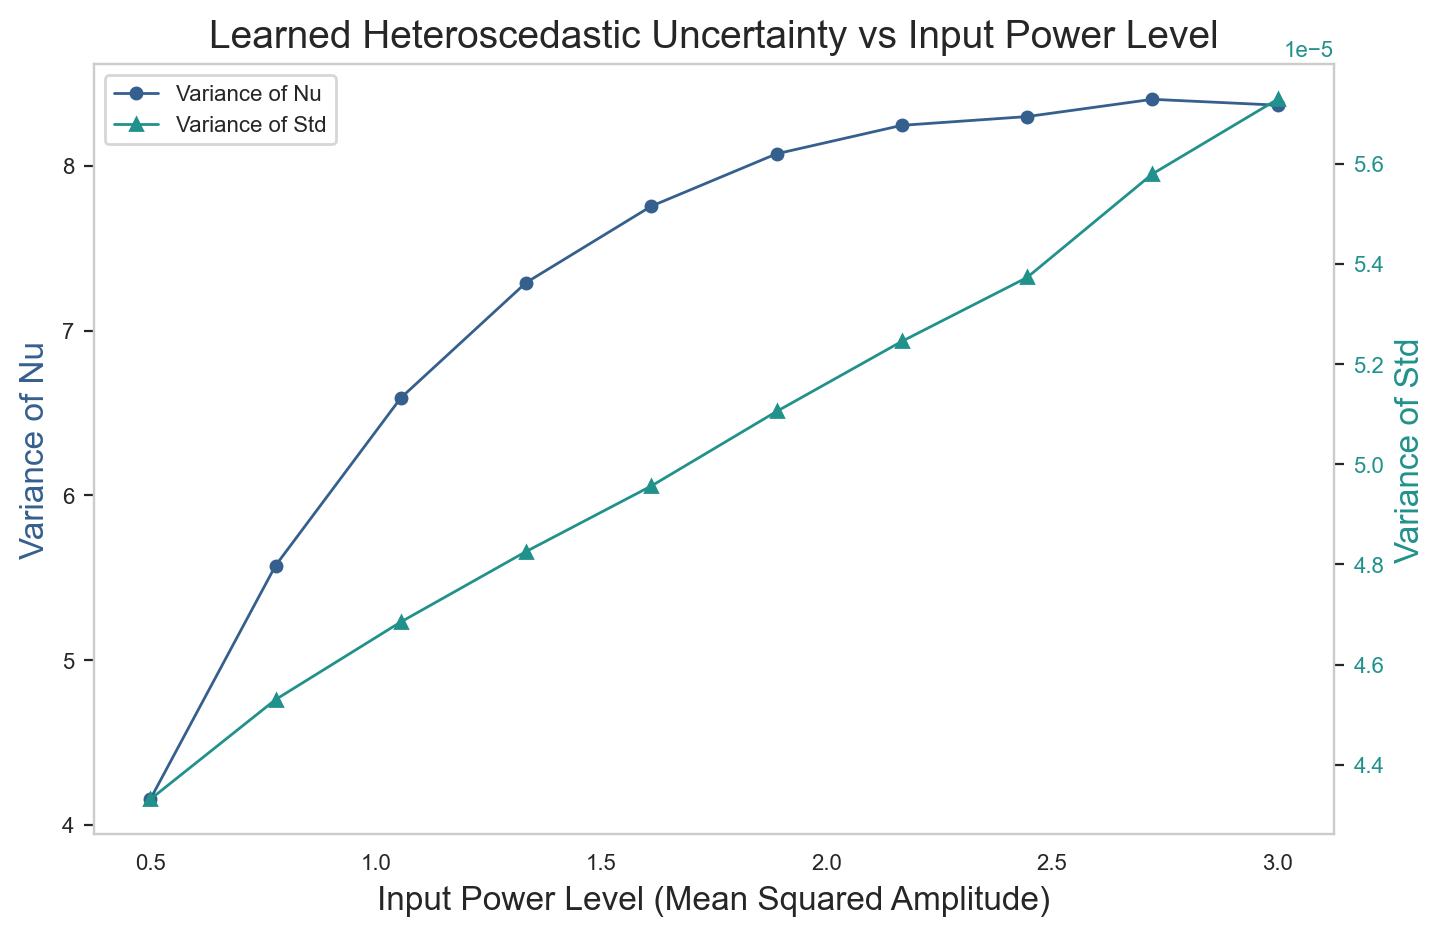

In [31]:
plt.rcParams.update({
    'figure.dpi': 200
})


tcn, _ = load_runs_final_artifact(models['48mA']['tcn_channel'], DEVICE, model_type='channel')

print(f"Is model Gaussian? {tcn.gaussian}")
fig, ax1 = plt.subplots(figsize=(8, 5))

power_levels = torch.linspace(0.5, 3.0, steps=10)
nu_variances = []
std_variances = []

with torch.no_grad():
    for power in power_levels:
        input_signal = torch.randn(1000, 1000).to(DEVICE) * torch.sqrt(power)
        noisy_y_pred, y_pred_tcn, std_y_pred, nu_y_pred = tcn(input_signal)


        # Trim by 2x receptive field to avoid edge effects
        receptive_field = tcn.receptive_field
        nu_y_pred = nu_y_pred[:, receptive_field:]
        std_y_pred = std_y_pred[:, receptive_field:]

        print(f"Mean Nu Prediction at power {power.item():.2f}: {nu_y_pred.mean().item():.4f} Max Nu Prediction: {nu_y_pred.max().item():.4f} Min Nu Prediction: {nu_y_pred.min().item():.4f} \
                Mean Std Prediction: {std_y_pred.mean().item():.4f} | Max Std Prediction: {std_y_pred.max().item():.4f} Min Std Prediction: {std_y_pred.min().item():.4f}")
        var_nu_y_pred = torch.var(nu_y_pred, dim=1).mean(dim=0).cpu().item()
        var_std_y_pred = torch.mean(std_y_pred**2, dim=1).mean(dim=0).cpu().item()
        nu_variances.append(var_nu_y_pred)
        std_variances.append(var_std_y_pred)

cmap = plt.get_cmap("viridis")
c_nu  = cmap(0.3)
c_std = cmap(0.5)

line1, = ax1.plot(power_levels.cpu(), nu_variances, marker='o',
                  label='Variance of Nu', color=c_nu)
ax1.set_ylabel('Variance of Nu', fontsize=12, color=c_nu)
ax1.tick_params(axis='y')

ax2 = ax1.twinx()
line2, = ax2.plot(power_levels.cpu(), std_variances, marker='^',
                  label='Variance of Std', color=c_std)
ax2.set_ylabel('Variance of Std', fontsize=12, color=c_std)
ax2.tick_params(axis='y', labelcolor=c_std)
plt.legend(handles=[line1, line2], loc="upper left")
plt.title('Learned Heteroscedastic Uncertainty vs Input Power Level', fontsize=14)
ax1.grid(False)
ax2.grid(False)
ax1.set_xlabel('Input Power Level (Mean Squared Amplitude)', fontsize=12)
plt.show()

Loading from ../models\channel_models\comfy-sweep-115\channel_model_final.pth


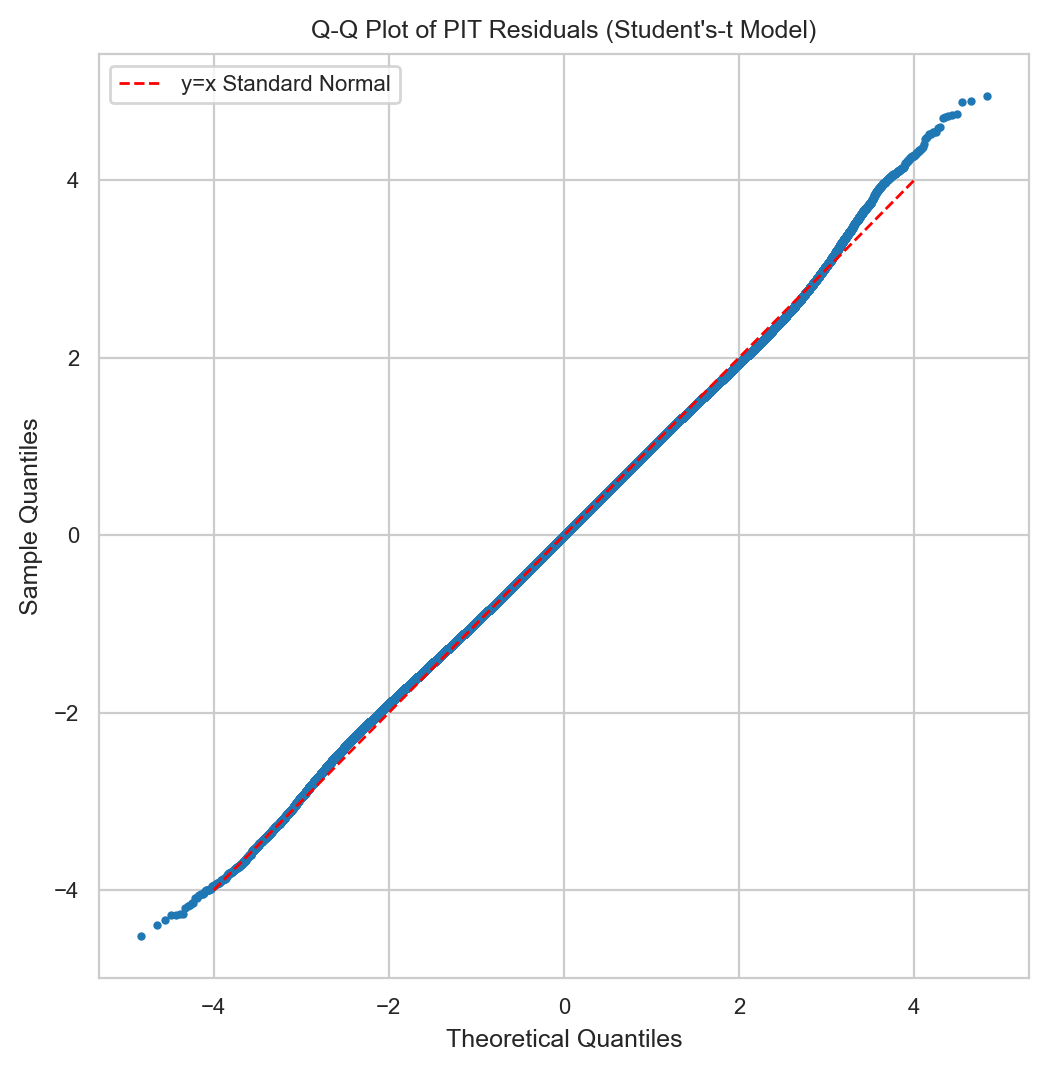

In [19]:
# G3: Visualize Learned Probability Distribution with Q-Q plot
plt.rcParams.update({
    'figure.dpi': 200,
})

tcn, _ = load_runs_final_artifact(models['48mA']['tcn_channel'], DEVICE, model_type='channel')
ofdm_info = models['48mA']['ofdm_info']

# If model is Gaussian, plot Q-Q plot of residuals. Otherwise, for the Student's-t
# model, we need to do a probability integral transform to get to a Gaussian using the CDF


X, Y = ofdm_info.sent_frames_time, ofdm_info.received_frames_time
y_pred_noisy, y_pred_mean, y_pred_std, y_pred_nu = tcn(X)

# collect residuals
r = (Y - y_pred_mean) / y_pred_std

# trim by receptive field
r = r[:, tcn.receptive_field:].detach().cpu().numpy().flatten()

# truncate to smaller amount for computational feasibility
N = r.shape[0]
MAX_SAMPLES = 1000000
indices = torch.randperm(N)[:MAX_SAMPLES]   
r = r[indices]
if tcn.gaussian:
    (osm, osr), _ = stats.probplot(r, dist="norm")
    plt.figure(figsize=(6, 6))
    plt.plot(osm, osr, marker='.', linestyle='none')
    plt.plot([-4, 4], [-4, 4], color='red', linestyle='--', label='y=x Standard Normal')
    plt.title("Q-Q Plot of Residuals (Gaussian Model)")
    plt.xlabel("Theoretical Quantiles")
    plt.ylabel("Sample Quantiles")
    plt.grid(True)
    plt.legend()
    plt.show()
else:
    # For Student's-t, do probability integral transform
    nu = y_pred_nu[:, tcn.receptive_field:].detach().cpu().numpy().flatten()
    nu = nu[indices]
    cdf_values = stats.t.cdf(r, df=nu)
    transformed_residuals = stats.norm.ppf(cdf_values) # Transform to standard normal using inverse CDF of normal
    (osm, osr), _ = stats.probplot(transformed_residuals, dist="norm")
    plt.figure(figsize=(6, 6))
    plt.plot(osm, osr, marker='.', linestyle='none')
    plt.plot([-4, 4], [-4, 4], color='red', linestyle='--', label='y=x Standard Normal')
    plt.title("Q-Q Plot of PIT Residuals (Student's-t Model)")
    plt.xlabel("Theoretical Quantiles")
    plt.ylabel("Sample Quantiles")
    plt.grid(True)  
    plt.legend()
    plt.show()